In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import time
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt


In [3]:
# ===================================
# Cell 2: Load and Explore the Dataset
# ===================================

# Load dataset from local CSV file
data = pd.read_csv("Iris.csv")  # make sure iris.csv is in the same directory

# Display dataset info
print("Dataset Preview:\n", data.head())
print("\nDataset Shape:", data.shape)
print("\nUnique Species:", data['species'].unique())

# Select only numeric columns for K-Means
X = data.iloc[:, :-1].values

# Standardize features for better clustering
scaler = StandardScaler()
X = scaler.fit_transform(X)

print("\nStandardized Feature Sample:\n", X[:5])


Dataset Preview:
    sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

Dataset Shape: (150, 5)

Unique Species: ['setosa' 'versicolor' 'virginica']

Standardized Feature Sample:
 [[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
 [-1.14301691 -0.13197948 -1.34022653 -1.3154443 ]
 [-1.38535265  0.32841405 -1.39706395 -1.3154443 ]
 [-1.50652052  0.09821729 -1.2833891  -1.3154443 ]
 [-1.02184904  1.24920112 -1.34022653 -1.3154443 ]]


In [4]:
# ======================================
# Cell 3: OPTIMIZED Sequential K-Means
# ======================================
def kmeans_sequential_optimized(X, k=3, max_iters=10):
    np.random.seed(42)
    n_samples = X.shape[0]
    centroids = X[np.random.choice(n_samples, k, replace=False)]

    for _ in range(max_iters):
        # Vectorized distance calculation - MUCH FASTER
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    return centroids, labels



In [5]:
# ======================================
# Cell 4: OPTIMIZED Parallel K-Means
# ======================================

def assign_cluster_chunk_optimized(args):
    """Optimized chunk assignment with vectorization"""
    X_chunk, centroids = args
    distances = np.linalg.norm(X_chunk[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def kmeans_parallel_optimized(X, k=3, max_iters=10):
    np.random.seed(42)
    n_samples = X.shape[0]
    centroids = X[np.random.choice(n_samples, k, replace=False)]

    # Use fewer processes for small datasets
    n_processes = min(cpu_count(), 4)  # Reduced from 8 to 4

    for _ in range(max_iters):
        # Create larger chunks to reduce overhead
        chunk_size = max(len(X) // n_processes, 50)  # Minimum chunk size
        chunks = [X[i:i + chunk_size] for i in range(0, len(X), chunk_size)]

        # Parallel assignment with optimized function
        with Pool(n_processes) as pool:
            results = pool.map(assign_cluster_chunk_optimized,
                             [(chunk, centroids) for chunk in chunks])

        # Combine results
        labels = np.concatenate(results)

        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    return centroids, labels


In [6]:
# ======================================================
# Cell 5: Compare Performance with OPTIMIZED versions
# ======================================================

print("Running Sequential K-Means...")
start_seq = time.time()
centroids_seq, labels_seq = kmeans_sequential_optimized(X, k=3)
end_seq = time.time()
time_seq = end_seq - start_seq

print("Running Parallel K-Means...")
start_par = time.time()
centroids_par, labels_par = kmeans_parallel_optimized(X, k=3)
end_par = time.time()
time_par = end_par - start_par

print("\n=== PERFORMANCE RESULTS ===")
print("Sequential K-Means Time: {:.4f} seconds".format(time_seq))
print("Parallel K-Means Time: {:.4f} seconds".format(time_par))

speedup = time_seq / time_par if time_par > 0 else 0
print("⚡ Speedup Achieved: {:.2f}x".format(speedup))



Running Sequential K-Means...
Running Parallel K-Means...

=== PERFORMANCE RESULTS ===
Sequential K-Means Time: 0.0046 seconds
Parallel K-Means Time: 0.2243 seconds
⚡ Speedup Achieved: 0.02x


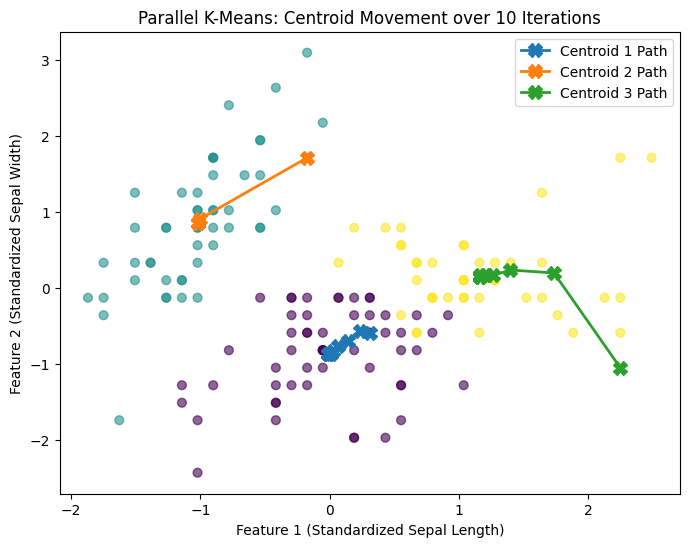

In [11]:
# ======================================
# Cell 6: Visualization of Clustering (All 10 Iterations in One Graph)
# ======================================

import matplotlib.pyplot as plt
import numpy as np

k = 3  # Number of clusters
max_iters = 10

np.random.seed(42)
centroids = X[np.random.choice(X.shape[0], k, replace=False)]

# Store centroid history for plotting
centroid_history = [centroids.copy()]

for it in range(max_iters):
    # Assign each point to nearest centroid
    labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)

    # Compute new centroids
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    centroid_history.append(new_centroids.copy())

    centroids = new_centroids

# --- Visualization ---
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=40, alpha=0.6)
plt.title("Parallel K-Means: Centroid Movement over 10 Iterations")
plt.xlabel("Feature 1 (Standardized Sepal Length)")
plt.ylabel("Feature 2 (Standardized Sepal Width)")

# Plot centroid movement paths
centroid_history = np.array(centroid_history)
for i in range(k):
    plt.plot(centroid_history[:, i, 0], centroid_history[:, i, 1],
             marker='X', markersize=10, linewidth=2, label=f'Centroid {i+1} Path')

plt.legend()
plt.show()

